<a href="https://colab.research.google.com/github/Hamid-Mofidi/PINNs/blob/main/Stochastic_Diffusion_Equation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stochastic heat Equation:  

# $y_t = y_{xx}  + σ  \frac{dW}{dt}$
 where $W$   is a Wiener process (Brownian motion), $\frac{dW}{dt}$ is the white noise term, and $σ$ is the noise strength.



# Initial condition: $y(x,0) = \sin(πx)$


# The exact solution is : $$ y(x,t) =  e^{-t}\sin(π x) + \int_{0}^t e^{-π^2(t-s)}σ ~dW(s) $$

The integral involving the Wiener process is a stochastic integral and requires proper mathematical treatment, often handled using Itô calculus or other stochastic calculus methods.

In [1]:
 ! pip install pyDOE

  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18168 sha256=028ab66137afeb69c9eef4274241ad7e6f09155dc5b2475b332de9f3bd296c1f
  Stored in directory: /root/.cache/pip/wheels/ce/b6/d7/c6b64746dba6433c593e471e0ac3acf4f36040456d1d160d17
Successfully built pyDOE


In [2]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from sklearn.model_selection import train_test_split

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda':
    print(torch.cuda.get_device_name())

cpu


# Tunning Parameters:

In [3]:

steps=20000
lr=1e-3
layers = np.array([2,32,32,1]) # hidden layers
# To generate new data:
x_min=-1
x_max=1
t_min=0
t_max=1
total_points_x=200
total_points_t=100
#Nu: Number of training points # Nf: Number of collocation points (Evaluate PDE)
Nu=100
Nf=10000


# Auxiliary Functions:

In [4]:
def plot3D(x,t,y):
  x_plot =x.squeeze(1)
  t_plot =t.squeeze(1)
  X,T= torch.meshgrid(x_plot,t_plot)
  F_xt = y
  fig,ax=plt.subplots(1,1)
  cp = ax.contourf(T,X, F_xt,20,cmap="rainbow")
  fig.colorbar(cp) # Add a colorbar to a plot
  ax.set_title('F(x,t)')
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  plt.show()
  ax = plt.axes(projection='3d')
  ax.plot_surface(T.numpy(), X.numpy(), F_xt.numpy(),cmap="rainbow")
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  ax.set_zlabel('f(x,t)')
  plt.show()

In [5]:

def plot3D_Matrix(x,t,y):
  X,T= x,t
  F_xt = y
  fig,ax=plt.subplots(1,1)
  cp = ax.contourf(T,X, F_xt,20,cmap="rainbow")
  fig.colorbar(cp) # Add a colorbar to a plot
  ax.set_title('F(x,t)')
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  plt.show()
  ax = plt.axes(projection='3d')
  ax.plot_surface(T.numpy(), X.numpy(), F_xt.numpy(),cmap="rainbow")
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  ax.set_zlabel('f(x,t)')
  plt.show()

# Functions:

Stochastic differential equations (SDEs) often lack closed-form solutions, and finding an exact solution can be challenging. The presence of stochastic (random) terms makes it difficult to derive explicit solutions. In many cases, researchers resort to numerical methods or simulations to analyze the behavior of the system.

For your stochastic partial differential equation (SPDE), which includes the stochastic term $σ dW/dt$, it may not have a known exact solution. In such cases, you can focus on solving and simulating the behavior of the SPDE using numerical methods, such as the one you implemented with the PINNs approach.

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
sigma = 0.1
pi = np.pi
T = 1.0  # Total time
N = 1000  # Number of time steps
dt = T / N  # Time step size

In [40]:
def initial_condition(x):
    return np.sin(pi * x)

In [41]:
# Generate Wiener process samples
dW = np.sqrt(dt) * np.random.randn(N)


def exact_solution(x, t):
    deterministic_part = np.exp(-t) * np.sin(pi * x)
    stochastic_part = np.zeros_like(x)
    for i in range(len(x)):
        stochastic_part[i] = np.sum(np.exp(-pi**2 * (t - np.linspace(0, t, N))) * sigma * dW)
    return deterministic_part + stochastic_part * np.sqrt(dt)

In [42]:
# Spatial discretization
x_values = np.linspace(0, 1, 100)

# Time discretization
t_values = np.linspace(0, T, N)

In [43]:
# Evaluate the exact solution at different times
u_values = np.zeros((len(t_values), len(x_values)))
for i, t in enumerate(t_values):
    u_values[i, :] = exact_solution(x_values, t)

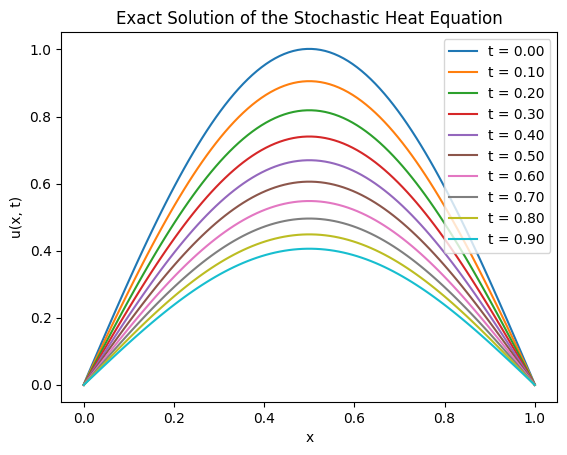

In [44]:
# Plot the solution
for i in range(0, len(t_values), int(N / 10)):
    plt.plot(x_values, u_values[i, :], label=f't = {t_values[i]:.2f}')

plt.title('Exact Solution of the Stochastic Heat Equation')
plt.xlabel('x')
plt.ylabel('u(x, t)')
plt.legend()
plt.show()

# Neural Network:


In [6]:
class FCN(nn.Module):
  ##Neural Network:
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class
        'activation function'
        self.activation = nn.Tanh()
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        'Initialise neural network as a list using nn.Modulelist'
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.iter = 0 #For the Optimizer
        'Xavier Normal Initialization'
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)

    # Foward pass:
    def forward(self,x):
        if torch.is_tensor(x) != True:
            x = torch.from_numpy(x)
        a = x.float()
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = self.activation(z)
        a = self.linears[-1](a)
        return a

    # Loss Functions:
    # Loss BC:
    def lossBC(self,x_BC,y_BC):
      loss_BC=self.loss_function(self.forward(x_BC),y_BC)
      return loss_BC

    # Loss SPDE:
    def lossPDE(self,x_PDE):
      g=x_PDE.clone()
      g.requires_grad=True #Enable differentiation
      f=self.forward(g)
      f_x_t = autograd.grad(f,g,torch.ones([g.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0] #first derivative
      f_xx_tt = autograd.grad(f_x_t,g,torch.ones(g.shape).to(device), create_graph=True)[0]#second derivative
      f_t=f_x_t[:,[1]]# we select the 2nd element for t (the first one is x) (Remember the input X=[x,t])
      f_xx=f_xx_tt[:,[0]]# we select the 1st element for x (the second one is t) (Remember the input X=[x,t])
      # Include the stochastic term
      sigma = 0.1  # Adjust the noise strength as needed
      dW_dt = sigma * torch.randn(g.shape[0], 1).to(device)
      f=f_t-f_xx+ torch.exp(-g[:, 1:])* (torch.sin(np.pi * g[:, 0:1]) - np.pi ** 2 * torch.sin(np.pi * g[:, 0:1])) + sigma * dW_dt
      return self.loss_function(f,f_hat)

    def loss(self,x_BC,y_BC,x_PDE):
      loss_bc=self.lossBC(x_BC,y_BC)
      loss_pde=self.lossPDE(x_PDE)
      return loss_bc+loss_pde

# Generate data:


In [7]:
x=torch.linspace(x_min,x_max,total_points_x).view(-1,1)
t=torch.linspace(t_min,t_max,total_points_t).view(-1,1)
# Create the mesh
X,T=torch.meshgrid(x.squeeze(1),t.squeeze(1))
# X[0,:] = [-1,...,-1],..., X[99,:] = [-0.005,...,-0.005], X[100,:] = [0.005,...,0.005],..., , X[199,:] = [1.,...,1.]
# T[:,0] = [0.,...,0.],..., T[:,49] = [0.4949,...,0.4949], T[:,50] = [0.5051,...,0.5051],..., , T[:,99] = [1.,...,1.]
# Evaluate real function
#y_real=f_real(X,T)
print(x.shape,t.shape)
print(X.shape,T.shape)
#print(X[199,:])
#print(T[:,50])


torch.Size([200, 1]) torch.Size([100, 1])
torch.Size([200, 100]) torch.Size([200, 100])


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


# Prepare Data:


In [8]:
# Transform the mesh into a 2-column vector
x_domain=torch.hstack((X.transpose(1,0).flatten()[:,None],T.transpose(1,0).flatten()[:,None]))
# Domain bounds
lb=x_domain[0] #first value
ub=x_domain[-1] #last value
print(x_domain.shape)
print(lb,ub)


torch.Size([20000, 2])
tensor([-1.,  0.]) tensor([1., 1.])


# Training Data:


In [9]:
#Initial Condition
#Left Edge: x(x,0)=sin(x)->xmin=<x=<xmax; t=0
left_X=torch.hstack((X[:,0][:,None],T[:,0][:,None])) # First column # The [:,None] is to give it the right dimension
left_Y=torch.sin(np.pi*left_X[:,0]).unsqueeze(1)
#Boundary Conditions
#Bottom Edge: x=min; tmin=<t=<max
bottom_X=torch.hstack((X[0,:][:,None],T[0,:][:,None])) # First row # The [:,None] is to give it the right dimension
bottom_Y=torch.zeros(bottom_X.shape[0],1)
#Top Edge: x=max; 0=<t=<1
top_X=torch.hstack((X[-1,:][:,None],T[-1,:][:,None])) # Last row # The [:,None] is to give it the right dimension
top_Y=torch.zeros(top_X.shape[0],1)
#Get all the training data into the same dataset
X_train=torch.vstack([left_X,bottom_X,top_X])
Y_train=torch.vstack([left_Y,bottom_Y,top_Y])
#Choose(Nu) points of our available training data:
idx=np.random.choice(X_train.shape[0],Nu,replace=False)
X_train_Nu=X_train[idx,:]
Y_train_Nu=Y_train[idx,:]
# Collocation Points (Evaluate our PDe)
#Choose(Nf) points(Latin hypercube)
X_train_Nf=lb+(ub-lb)*lhs(2,Nf) # 2 as the inputs are x and t
X_train_Nf=torch.vstack((X_train_Nf,X_train_Nu)) #Add the training poinst to the collocation points


In [12]:
print("Original shapes for X and Y:",X.shape)
print("Boundary shapes for the edges:",left_X.shape,bottom_X.shape,top_X.shape)
print("Available training data:",X_train.shape,Y_train.shape)
print("Final training data:",X_train_Nu.shape,Y_train_Nu.shape)
print("Total collocation points:",X_train_Nf.shape)

Original shapes for X and Y: torch.Size([200, 100])
Boundary shapes for the edges: torch.Size([200, 2]) torch.Size([100, 2]) torch.Size([100, 2])
Available training data: torch.Size([400, 2]) torch.Size([400, 1])
Final training data: torch.Size([100, 2]) torch.Size([100, 1])
Total collocation points: torch.Size([10100, 2])


## Train Neural Network:

In [13]:
torch.manual_seed(123)
#Store tensors to GPU
X_train_Nu=X_train_Nu.float().to(device)#Training Points (BC)
Y_train_Nu=Y_train_Nu.float().to(device)#Training Points (BC)
X_train_Nf=X_train_Nf.float().to(device)#Collocation Points
f_hat = torch.zeros(X_train_Nf.shape[0],1).to(device)#to minimize function

#X_test=x_test.float().to(device) # the input dataset (complete)
#Y_test=y_test.float().to(device) # the real solution


#Create Model
PINN = FCN(layers)
PINN.to(device)
print(PINN)
params = list(PINN.parameters())
optimizer = torch.optim.Adam(PINN.parameters(),lr=lr,amsgrad=False)
'''
'L-BFGS Optimizer'
optimizer = torch.optim.LBFGS(PINN.parameters(), lr=lr,
                              max_iter = steps,
                              max_eval = None,
                              tolerance_grad = 1e-05,
                              tolerance_change = 1e-09,
                              history_size = 100,
                              line_search_fn = 'strong_wolfe')'''
start_time = time.time()


FCN(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [15]:
for i in range(steps):
    if i==0:
      print("Training Loss-----Test Loss")
    loss = PINN.loss(X_train_Nu,Y_train_Nu,X_train_Nf)# use mean squared error
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i%(steps/10)==0:
      #with torch.no_grad():
        #test_loss=PINN.lossBC(X_test,Y_test)
      #print(loss.detach().cpu().numpy(),'---',test_loss.detach().cpu().numpy())
      print(loss.detach().cpu().numpy())


Training Loss-----Test Loss
16.873404
0.0024149232
0.0011382665
0.00059155526
0.00033934668
0.00026757873
0.00034354939
0.00019096321
0.00019579877
0.00038416282
